<h1>Table of Contents<span class="tocSkip"></span></h1>
<div class="toc"><ul class="toc-item"><li><span><a href="#Purpose" data-toc-modified-id="Purpose-1"><span class="toc-item-num">1&nbsp;&nbsp;</span>Purpose</a></span></li><li><span><a href="#Input" data-toc-modified-id="Input-2"><span class="toc-item-num">2&nbsp;&nbsp;</span>Input</a></span></li><li><span><a href="#Output" data-toc-modified-id="Output-3"><span class="toc-item-num">3&nbsp;&nbsp;</span>Output</a></span></li><li><span><a href="#Parameters" data-toc-modified-id="Parameters-4"><span class="toc-item-num">4&nbsp;&nbsp;</span>Parameters</a></span><ul class="toc-item"><li><span><a href="#Not-through-papermill" data-toc-modified-id="Not-through-papermill-4.1"><span class="toc-item-num">4.1&nbsp;&nbsp;</span>Not through papermill</a></span></li></ul></li><li><span><a href="#Load-Cell-Metadata" data-toc-modified-id="Load-Cell-Metadata-5"><span class="toc-item-num">5&nbsp;&nbsp;</span>Load Cell Metadata</a></span></li><li><span><a href="#Basic-metrics-distribution" data-toc-modified-id="Basic-metrics-distribution-6"><span class="toc-item-num">6&nbsp;&nbsp;</span>Basic metrics distribution</a></span></li><li><span><a href="#Filter-by-basic-QC-metrics" data-toc-modified-id="Filter-by-basic-QC-metrics-7"><span class="toc-item-num">7&nbsp;&nbsp;</span>Filter by basic QC metrics</a></span></li><li><span><a href="#Other-Stats" data-toc-modified-id="Other-Stats-8"><span class="toc-item-num">8&nbsp;&nbsp;</span>Other Stats</a></span></li><li><span><a href="#Plateview-of-key-metrics" data-toc-modified-id="Plateview-of-key-metrics-9"><span class="toc-item-num">9&nbsp;&nbsp;</span>Plateview of key metrics</a></span></li></ul></div>

# Basic Data Walkthrough and Cell Mapping Metric Filtering

## Purpose
- Overview of basic QC metrics per brain region
- Have a simple cell filtering based on basic QC metrics

## Input
- Cell metadata table

## Output
- Selected cell metadata table

In [1]:
import warnings
warnings.filterwarnings('ignore')

In [2]:
import pathlib

import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import seaborn as sns
from cemba_data.plot.preprocessing import cutoff_vs_cell_remain, plot_on_plate

In [3]:
result_dir = pathlib.Path()
fig_dir = result_dir / 'fig/cell_basic_qc'
fig_dir.mkdir(exist_ok=True, parents=True)

## Parameters

In [4]:
# parameters cell
study_name = ''

cell_metadata_path = ''

In [5]:
# Parameters
study_name = "6C"
cell_metadata_path = "/home/hanliu/project/mouse_rostral_brain/study/DissectionRegions/6C/CellMetadata.msg"


### Not through papermill

In [6]:
# QC metric filtering
qc_metric = {
    'CCC_Rate': (0, 0.05),
    'CG_RateAdj': (0.5, 1),
    'CH_RateAdj': (0., 0.15),
    'FinalReads': (500000, 10000000),
    'MappingRate': (0.5, 1)
}

# plot cell metadata columns
metadata_distribution_plot = {
    'CCC_Rate': (0., 0.1),
    'CH_RateAdj': (0, 0.1),
    'CG_RateAdj': (0.7, 0.9),
    'InputReads': (0, 1e7),
    'MappedReads': (0, 1e7),
    'FinalReads': (0, 1e7),
    'MappingRate': (0.5, 1)
}

final_reads_column = 'FinalReads'
plate_view = False

## Load Cell Metadata

In [7]:
total_cell_meta = pd.read_msgpack(cell_metadata_path)

In [8]:
cell_metadata_include = {}
cell_metadata_exclude = {}

# apply cell metadata and cell list selection first
judges = []
for k, v in cell_metadata_include.items():
    judges.append(total_cell_meta[k].isin(v))
for k, v in cell_metadata_exclude.items():
    judges.append(~total_cell_meta[k].isin(v))

if len(judges) != 0:
    cell_meta = total_cell_meta[np.all(judges, axis=0)].copy()
else:
    cell_meta = total_cell_meta

## Basic metrics distribution

findfont: Font family ['sans-serif'] not found. Falling back to DejaVu Sans.


findfont: Font family ['sans-serif'] not found. Falling back to DejaVu Sans.


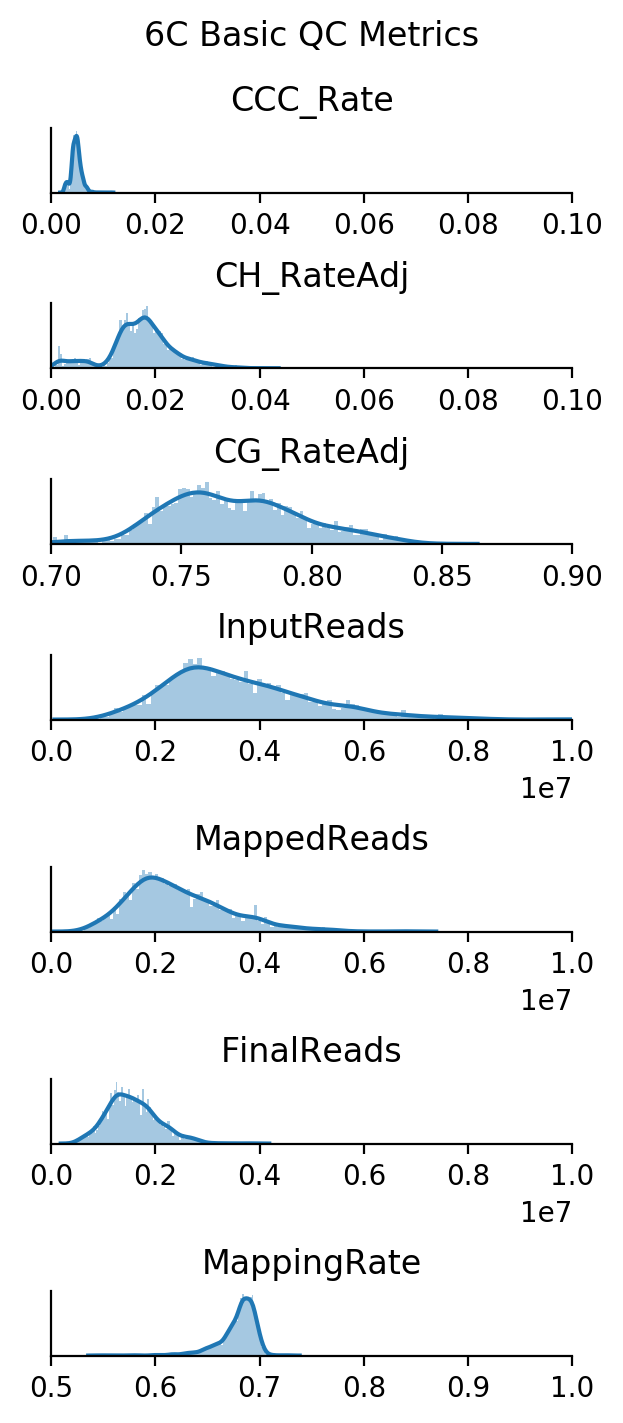

In [9]:
nrows = len(metadata_distribution_plot)
if nrows != 0:
    fig, axes = plt.subplots(nrows=nrows,
                             constrained_layout=True,
                             figsize=(3, nrows),
                             dpi=200)
    for (col, xlim), ax in zip(metadata_distribution_plot.items(), axes.flat):
        _data = cell_meta[col]
        _data = _data[(_data <= xlim[1]) & (_data >= xlim[0])]
        sns.distplot(_data, ax=ax, bins=100)
        ax.set(xlim=xlim, yticks=[], xlabel='', title=col)
    sns.despine(fig=fig, trim=True)

    fig.suptitle(f'{study_name} Basic QC Metrics')

    fig.savefig(fig_dir / f'basic_qc_metric.pdf')

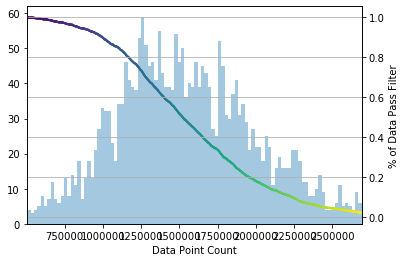

In [10]:
try:
    fig, axes = cutoff_vs_cell_remain(cell_meta[final_reads_column],
                                      xlim_quantile=(0.001, 0.98))
    fig.savefig(fig_dir / 'FinalReads distribution')
except KeyError:
    print(f'{final_reads_column} not in cell_meta, skip')

## Filter by basic QC metrics

In [11]:
judges = []
for col, (vmin, vmax) in qc_metric.items():
    judge = (cell_meta[col] >= vmin) & (cell_meta[col] <= vmax)
    print(
        f'{col} passed {judge.sum()}/{judge.size} ({(100*judge.sum()/judge.size):.1f}%)'
    )
    judges.append(judge)
cell_meta['PassFilter'] = np.all(judges, axis=0)

total_number = cell_meta['PassFilter'].sum()
print(
    f'Overall passed {total_number}/{judge.size} ({(100*total_number/cell_meta.shape[0]):.1f}%)'
)

CCC_Rate passed 2471/2471 (100.0%)
CG_RateAdj passed 2471/2471 (100.0%)
CH_RateAdj passed 2471/2471 (100.0%)
FinalReads passed 2471/2471 (100.0%)
MappingRate passed 2471/2471 (100.0%)
Overall passed 2471/2471 (100.0%)


In [12]:
cell_meta.to_msgpack('CellMetadata.AfterQC.msg')

## Other Stats

In [13]:
print('Cells pass basic QC in each batch:')
for k, v in cell_meta.groupby('FACS_Date')['PassFilter'].sum().astype(
        int).items():
    print(k, v)

Cells pass basic QC in each batch:
190122 1277
190124 1194


In [14]:
print('Cells pass basic QC in each random index:')
for k, v in cell_meta.groupby('index_name')['PassFilter'].sum().astype(
        int).items():
    print(k, v, f'{v/3.84:.1f}%')

Cells pass basic QC in each random index:
ad001 309 80.5%
ad002 304 79.2%
ad004 318 82.8%
ad006 319 83.1%
ad007 313 81.5%
ad008 297 77.3%
ad010 308 80.2%
ad012 303 78.9%


## Plateview of key metrics

In [15]:
if plate_view:
    fig, axes = plot_on_plate(cell_meta,
                              'FinalReads',
                              'Plate',
                              vmin=5e5,
                              vmax=3e6,
                              heatmap_kws={
                                  'linewidth': 0,
                                  'linecolor': '#EEEEEE'
                              },
                              aggregation_func=lambda i: i.mean())
    fig.savefig(fig_dir / f'384plate.FinalReads.pdf')

In [16]:
if plate_view:
    fig, axes = plot_on_plate(cell_meta,
                              'CG_RateAdj',
                              'Plate',
                              vmin=0.65,
                              vmax=0.85,
                              heatmap_kws={
                                  'linewidth': 0,
                                  'linecolor': '#EEEEEE'
                              },
                              aggregation_func=lambda i: i.mean())
    fig.savefig(fig_dir / f'384plate.CG_RateAdj.pdf')

In [17]:
if plate_view:
    fig, axes = plot_on_plate(cell_meta,
                              'CH_RateAdj',
                              'Plate',
                              vmin=0,
                              vmax=0.05,
                              heatmap_kws={
                                  'linewidth': 0,
                                  'linecolor': '#EEEEEE'
                              },
                              aggregation_func=lambda i: i.mean())
    fig.savefig(fig_dir / f'384plate.CH_RateAdj.pdf')

In [18]:
cell_meta

,AllcPath,CCC_Rate,CG_Rate,CG_RateAdj,CH_Rate,CH_RateAdj,FinalReads,InputReads,MappedReads,Region,...,l2-umap_0,l2-umap_1,l2-tsne_0,l2-tsne_1,SubType,l3-umap_0,l3-umap_1,l3-tsne_0,l3-tsne_1,PassFilter
6C_M_0,/gale/raidix/rdx-4/mapping/6C/CEMBA190122-6C-1...,0.004295,0.776806,0.775843,0.019565,0.015336,1394893.0,2967880,2052776.0,6C,...,6.263083,-15.366718,-23.202421,3.658026,IT-L4 Shc3,0.129749,-1.147177,-17.020120,17.798249,True
6C_M_100,/gale/raidix/rdx-4/mapping/6C/CEMBA190122-6C-1...,0.004555,0.759918,0.758819,0.020505,0.016023,1576664.0,3409300,2362304.0,6C,...,5.107458,-16.178568,-38.180564,2.194773,IT-L4 Shc3,0.469873,0.564623,-14.900132,10.420873,True
6C_M_1000,/gale/raidix/rdx-4/mapping/6C/CEMBA190122-6C-3...,0.004423,0.753749,0.752655,0.019010,0.014652,1716123.0,4733996,3199326.0,6C,...,-3.363926,-12.994389,-15.130556,58.998912,IT-L23 Cux1,4.547367,10.496509,34.818334,-30.788214,True
6C_M_1001,/gale/raidix/rdx-4/mapping/6C/CEMBA190122-6C-3...,0.004686,0.798479,0.797531,0.022044,0.017440,748467.0,2417140,1488779.0,6C,...,22.525864,6.362612,-34.619102,-10.230377,CT-L6 Megf9,-7.828167,-18.852917,-18.450232,15.134271,True
6C_M_1002,/gale/raidix/rdx-4/mapping/6C/CEMBA190122-6C-3...,0.004074,0.764441,0.763478,0.017340,0.013321,1944311.0,5285480,3664438.0,6C,...,20.369349,4.550290,-49.820887,-8.795952,CT-L6 Megf9,-7.730803,-9.193746,-3.982671,36.559405,True
6C_M_1003,/gale/raidix/rdx-4/mapping/6C/CEMBA190122-6C-3...,0.004623,0.757169,0.756042,0.020243,0.015693,1208930.0,2673192,1866008.0,6C,...,3.845605,-17.660168,-56.106098,9.745142,IT-L4 Astn2,-0.384564,7.753616,15.577206,-21.076863,True
6C_M_1004,/gale/raidix/rdx-4/mapping/6C/CEMBA190122-6C-3...,0.005769,0.821912,0.820878,0.030144,0.024516,1382328.0,3117934,2169350.0,6C,...,-21.334057,0.549735,-31.024293,-11.696752,MGE-Sst Bmper,-3.100222,-11.133056,9.148304,25.687830,True
6C_M_1005,/gale/raidix/rdx-4/mapping/6C/CEMBA190122-6C-3...,0.005385,0.785324,0.784161,0.025254,0.019977,1607216.0,3639772,2518009.0,6C,...,15.471554,-10.713778,34.555067,18.977710,IT-L6 Cadps2,0.308344,-3.399956,-33.069670,6.864221,True
6C_M_1006,/gale/raidix/rdx-4/mapping/6C/CEMBA190122-6C-3...,0.004649,0.759550,0.758427,0.020120,0.015543,1709702.0,3885152,2678912.0,6C,...,1.981156,-15.369326,1.941884,51.491179,IT-L23 Cux1,-4.421150,9.050051,-10.587174,-36.935006,True
6C_M_1007,/gale/raidix/rdx-4/mapping/6C/CEMBA190122-6C-3...,0.004243,0.762389,0.761377,0.018579,0.014397,1280877.0,2883538,2019337.0,6C,...,18.965807,5.434807,-54.884887,-14.538564,CT-L6 Il1rap,-11.120886,-13.307491,17.767490,38.476555,True
